# **A Deep Learning Approach for Intrusion Detection Using Recurrent Neural Networks**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io

In [2]:
#training set
df = pd.read_csv("/home/ids/NT114.O11.ATCL-IDS/Datasets/NSL-KDD/csv/KDDTrain+.csv")
#testing set
df_test = pd.read_csv("/home/ids/NT114.O11.ATCL-IDS/Datasets/NSL-KDD/csv/KDDTest+.csv")

# Dropping redundant features
df = df.drop(['r'], axis = 1)
df_test = df_test.drop(['r'], axis = 1)

In [3]:
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [4]:
print('Label distribution in the Training set:')
print("****************************************")
print(df['label'].value_counts())

Label distribution in the Training set:
****************************************
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


In [5]:
print('Label distribution in the Test set:')
print("**************************************")
print(df_test['label'].value_counts())

Label distribution in the Test set:
**************************************
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: label, 

# **Data preprocessing:**

One-Hot-Encoding is used to convert all categorical properties to binary properties. One-Hot-Endcoding requirement, the input to this transformer must be an integer matrix expressing values taken with categorical (discrete) properties. The output will be a sparse matrix in which each column corresponds to a possible value. It is assumed that the input properties have values in the range [0, n_values]. Therefore, to convert each category to a number, properties must first be converted with LabelEncoder.

In [6]:
# columns are categorical, not yet binary: protocol_type (column 2), service (column 3), flag (column 4).

print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [7]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


**LabelEncoder**

**Insert categorical features into a 2D numpy array**

In [8]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]

df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [9]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

**Transform categorical features into numbers using LabelEncoder()**

In [10]:
# train set
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


**One-Hot-Encoding**

In [11]:
# train set
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

Missing columns in test set are added 




In [12]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]

for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)    
print(testdf_cat_data.shape)

(125973, 84)
(22544, 84)


New numeric columns are added to main dataframe

In [13]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


In [14]:
# Convert the "label" catagorical values into numerical values

labeldf=newdf['label']
labeldf_test=newdf_test['label']

# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



In [15]:
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [16]:
#Convert "label" into normal=0 and attack=1 for KDDTrain+
newdf['class']=newdf['label'].apply(lambda x: 1 if x>=1 else 0)
newdf.drop(['label'], axis=1)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
125969,8,105,145,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125970,0,2231,384,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125971,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [17]:
#Convert "label" into normal=0 and attack=1 for KDDTest+
newdf_test['class']=newdf_test['label'].apply(lambda x: 1 if x>=1 else 0)
newdf_test.drop(['label'],1)

/home/ids/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S3,flag_SF,flag_SH,service_red_i,service_harvest,service_aol,service_http_8001,service_urh_i,service_http_2784,class
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0,0,0,0,0,0,1
4,1,0,15,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
22540,0,317,938,0,0,0,0,0,1,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0.0,1.0,0.0,0,0,0,0,0,0,1
22542,0,42,42,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0


In [18]:
newdf.groupby('class').count()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
class,,,,,,,,,,,,,,,,,,,,,
0,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,...,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343
1,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,...,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630


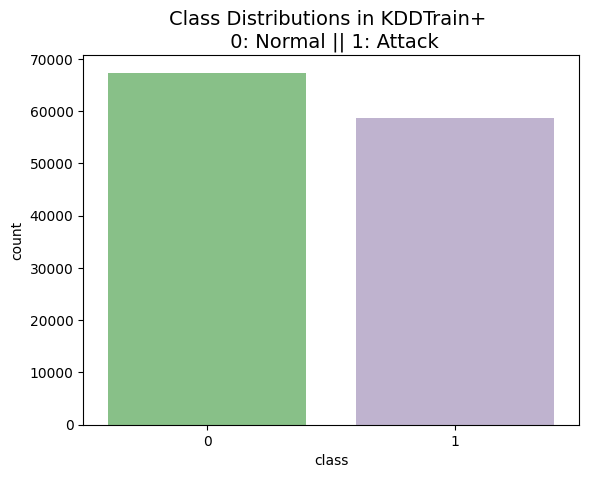

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.countplot(x="class", data=newdf, palette="Accent")
plt.title('Class Distributions in KDDTrain+ \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

In [20]:
newdf_test.groupby('class').count()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S2,flag_S3,flag_SF,flag_SH,service_red_i,service_harvest,service_aol,service_http_8001,service_urh_i,service_http_2784
class,,,,,,,,,,,,,,,,,,,,,
0,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,...,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711
1,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,...,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833


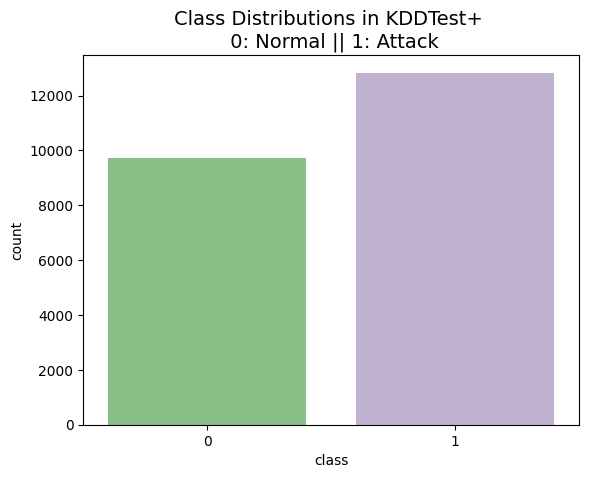

In [21]:
sns.countplot(x="class", data=newdf_test, palette="Accent")
plt.title('Class Distributions in KDDTest+ \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

**Feature Scaling**

In [22]:
# step1: apply the logarithmic scaling method for scaling to obtain the ranges of `duration[0,4.77]', `src_bytes[0,9.11]' and `dst_bytes[0,9.11]
newdf['log2_value1'] = np.log2(newdf['duration'])
newdf['log2_value2'] = np.log2(newdf['src_bytes'])
newdf['log2_value3'] = np.log2(newdf['dst_bytes'])
newdf=newdf.drop(['log2_value3','log2_value2','log2_value1'], axis=1)


# testing set

newdf_test['log2_value1'] = np.log2(newdf_test['duration'])
newdf_test['log2_value2'] = np.log2(newdf_test['src_bytes'])
newdf_test['log2_value3'] = np.log2(newdf_test['dst_bytes'])
newdf_test=newdf_test.drop(['log2_value3','log2_value2','log2_value1'], axis=1)

print(newdf)
print(newdf_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


        duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0              0        491          0     0               0       0    0   
1              0        146          0     0               0       0    0   
2              0          0          0     0               0       0    0   
3              0        232       8153     0               0       0    0   
4              0        199        420     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
125968         0          0          0     0               0       0    0   
125969         8        105        145     0               0       0    0   
125970         0       2231        384     0               0       0    0   
125971         0          0          0     0               0       0    0   
125972         0        151          0     0               0       0    0   

        num_failed_logins  logged_in  num_compromised  ...  flag_RSTO  \
0 

**Split the training set and testing set**

In [23]:
x=newdf.drop('class',1) #X-train
y=newdf["class"] #y-Train
xtest=newdf_test.drop("class",1) #X-test
ytest=newdf_test['class'] # y-test
xtest

/home/ids/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/home/ids/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S2,flag_S3,flag_SF,flag_SH,service_red_i,service_harvest,service_aol,service_http_8001,service_urh_i,service_http_2784
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
4,1,0,15,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
22540,0,317,938,0,0,0,0,0,1,0,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
22542,0,42,42,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0


In [24]:
# Step 2: the value of every feature is mapped to the [0,1] range linearly
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
# Training Set
scale = MinMaxScaler()
scale= preprocessing.StandardScaler().fit(x)
x=scale.transform(x) 
scaletest= preprocessing.StandardScaler().fit(xtest)
xtest=scaletest.transform(xtest)

# **RNN Model**

**Input layer**

LSTM input layer must be 3D
the meaning of the 3 input dimensions are: samples, time steps, and features.
The number of samples is assumed to be 1 or more.
reshape() function takes a tuple as an argument that defines the new shape.
number_of_rows_to_process_each_loop, the_time_interval_for_next_move(e.g. per day, per month), column

In [25]:
from tensorflow import keras
import numpy as np
import datetime
import time
x=pd.DataFrame(x)
x = x.values
sample = x.shape[0]
features = x.shape[1]
#Train: convert 2D to 3D for input RNN
x_train = np.reshape(x,(sample,features,1)) #shape  = (125973, 18, 1)
#Test: convert 2D to 3D for input RNN
x_test=pd.DataFrame(xtest)
x_test = x_test.values
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

**Following the research paper**

Number of neuron in the hidden layer=80

The activation function in the hidden layer is sigmoid, in the output layer is softmax function.

In [26]:
Model = keras.Sequential([

        keras.layers.LSTM(80,input_shape=(features,x_train.shape[2]),
                          activation='sigmoid',recurrent_activation='hard_sigmoid'),
        keras.layers.Dense(1,activation="softmax")
    ])

Model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

#Training the model

Model.fit(x_train, y, epochs=10, batch_size= 32) 
Model.summary()

# Final evaluation of the model
scores = Model.evaluate(x_test, ytest, verbose=0)
print('/n')
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 125973 samples


2024-01-05 10:21:32.862716: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-05 10:21:32.862757: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-05 10:21:32.862794: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu22): /proc/driver/nvidia/version does not exist
2024-01-05 10:21:32.864358: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-01-05 10:21:32.893873: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1997685000 Hz
2024-01-05 10:21:32.896169: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xab97760 initialized for platform Host (this does not guarantee that XLA wil

Epoch 1/10
125973/125973 [==============================] - 823s 7ms/sample - loss: 0.5346 - acc: 0.4654
Epoch 2/10
125973/125973 [==============================] - 561s 4ms/sample - loss: 0.5346 - acc: 0.4654
Epoch 3/10
125973/125973 [==============================] - 547s 4ms/sample - loss: 0.5346 - acc: 0.4654
Epoch 4/10
125973/125973 [==============================] - 550s 4ms/sample - loss: 0.5346 - acc: 0.4654
Epoch 5/10
125973/125973 [==============================] - 553s 4ms/sample - loss: 0.5346 - acc: 0.4654
Epoch 6/10
125973/125973 [==============================] - 554s 4ms/sample - loss: 0.5346 - acc: 0.4654
Epoch 7/10
125973/125973 [==============================] - 550s 4ms/sample - loss: 0.5346 - acc: 0.4654
Epoch 8/10
125973/125973 [==============================] - 544s 4ms/sample - loss: 0.5346 - acc: 0.4654
Epoch 9/10
125973/125973 [==============================] - 547s 4ms/sample - loss: 0.5346 - acc: 0.4654
Epoch 10/10
125973/125973 [============================

**To modify the results:**

number of neurons in the hidden layer is 80 neurons

Activation function: I used the hard_sigmoid in the hidden layer
and tanh in the output layer

In [27]:
# Using tanh and sigmoid as activation functions

Model_tanh = keras.Sequential([

        keras.layers.LSTM(80,input_shape=(features,x_train.shape[2]),
                          activation='tanh',recurrent_activation='hard_sigmoid'),
        keras.layers.Dense(1,activation="tanh")
    ])

Model_tanh.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

#Training the model
Model_tanh.fit(x_train, y, epochs=10, batch_size= 32) 
Model_tanh.summary()

# Final evaluation of the model
scores = Model_tanh.evaluate(x_test, ytest, verbose=0)
print("/n")
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 125973 samples
Epoch 1/10
125973/125973 [==============================] - 490s 4ms/sample - loss: 0.0643 - acc: 0.9213
Epoch 2/10
125973/125973 [==============================] - 495s 4ms/sample - loss: 0.0162 - acc: 0.9814
Epoch 3/10
125973/125973 [==============================] - 493s 4ms/sample - loss: 0.0056 - acc: 0.9939
Epoch 4/10
125973/125973 [==============================] - 494s 4ms/sample - loss: 0.0035 - acc: 0.9961
Epoch 5/10
125973/125973 [==============================] - 494s 4ms/sample - loss: 0.0052 - acc: 0.9943
Epoch 6/10
125973/125973 [==============================] - 498s 4ms/sample - loss: 0.0025 - acc: 0.9972
Epoch 7/10
125973/125973 [==============================] - 495s 4ms/sample - loss: 0.0020 - acc: 0.9978
Epoch 8/10
125973/125973 [==============================] - 497s 4ms/sample - loss: 0.0151 - acc: 0.9814
Epoch 9/10
125973/125973 [==============================] - 499s 4ms/sample - loss: 0.0030 - acc: 0.9967
Epoch 10/10
125973/125973 [====

# **Applying RNN with Meta-learning**

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import learn2learn as l2l

/usr/local/lib/python3.7/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Convert LSTM RNN model to Pytorch model

In [61]:
class PyTorchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(PyTorchRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.tanh(self.fc(output[:, -1, :]))
        return output

In [62]:
# Converting the Keras model to PyTorch
input_shape = x_train.shape[2]
hidden_size = 80
output_size = 1

# # Extract weights from Keras model
# weights = [torch.tensor(w) for w in Model.get_weights()]

In [63]:
# Define the PyTorch LSTM model
pytorch_rnn = PyTorchRNN(input_shape, hidden_size, output_size)

In [64]:
# Set PyTorch model to evaluation model
pytorch_rnn.eval()

PyTorchRNN(
  (lstm): LSTM(1, 80, batch_first=True)
  (fc): Linear(in_features=80, out_features=1, bias=True)
  (tanh): Tanh()
)

## Convert data to Pytorch tensors

In [65]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(ytest, dtype=torch.long)

In [66]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)

In [67]:
test_data = TensorDataset(x_test_tensor, y_test_tensor)

## Create MetaDataset for meta-training and meta-testing

In [ ]:
# meta_train = l2l.data.MetaDataset(train_data)
# meta_train_task = l2l.data.TaskDataset(meta_train, 
#                                        task_transforms=[
#                                             l2l.data.transforms.NWays(meta_train, 1),
#                                             l2l.data.transforms.KShots(meta_train, 5),
#                                             l2l.data.transforms.LoadData(meta_train),
#                                             l2l.data.transforms.ConsecutiveLabels(meta_train)
#                                             ], num_tasks=1000)

In [ ]:
# meta_test = l2l.data.MetaDataset(test_data)
# meta_test_task = l2l.data.TaskDataset(meta_test, 
#                                        task_transforms=[
#                                             l2l.data.transforms.NWays(meta_test, 1),
#                                             l2l.data.transforms.KShots(meta_test, 5),
#                                             l2l.data.transforms.LoadData(meta_test),
#                                             l2l.data.transforms.ConsecutiveLabels(meta_test),
#                                             ], num_tasks=20)

In [68]:
btch_sz = 32
train_loader = DataLoader(train_data, batch_size=btch_sz, shuffle=True)
test_loader = DataLoader(test_data,batch_size=btch_sz, shuffle=False)

## MAML-RNN

In [69]:
maml_rnn = l2l.algorithms.MAML(pytorch_rnn, lr=0.01)

In [70]:
meta_optimizer = torch.optim.Adam(maml_rnn.parameters(), lr=0.001)

In [71]:
loss = torch.nn.BCEWithLogitsLoss()

In [72]:
num_iteration = 1000
ways = 5
shots = 5

## Meta-training

In [ ]:
# for iteration in range(20000):
#     meta_optimizer.zero_grad()
#     meta_train_error = 0.0
#     meta_train_accuracy = 0.0
#     meta_valid_error = 0.0
#     meta_valid_accuracy = 0.0
#     for task in range(len(meta_train_task)):
#         # Compute meta-training loss
#         learner = maml_rnn.clone()
#         batch = meta_train_task.sample()
#         evaluation_error, evaluation_accuracy = fast_adapt(batch, learner, loss, 1, 5, 1)
#         evaluation_error.backward()
#         meta_train_error += evaluation_error.item()
#         meta_train_accuracy += evaluation_accuracy.item()
#     # Print some metrics
#     print('\n')
#     print('Meta Train Error', meta_train_error / 4)
#     print('Meta Train Accuracy', meta_train_accuracy / 4)
#     meta_optimizer.step()

In [73]:
for epoch in range(num_iteration):
    print("Epoch: ", epoch)
    for batch in train_loader:
        # Split the batch into support and query sets
        support = ways * shots
        support_dt, query_dt = batch[:support], batch[support:]

        # Handle varying dimensions in support data
        support_tensors = [item[0] for item in support_dt if item[0].dim() > 0]
        if len(support_tensors) == 0:
            # Skip if there are no valid errors
            continue
        support_dt = torch.stack([item.unsqueeze(0) for item in support_tensors], dim=0)

        # Handle varying dimensions in support data
        query_tensors = [item[0] for item in query_dt if item[0].dim() > 0]
        if(len(query_tensors) == 0):
            # Skip if there are no valid errors
            continue
        query_dt = torch.stack([item.unsqueeze(0) for item in query_tensors], dim = 0)

        # Meta-training
        adapted_model = maml_rnn.clone()
        support_loss = adapted_model(support_dt)
        adapted_model.adapt(support_loss)
        query_loss = adapted_model(query_dt)

        meta_optimizer.zero_grad()
        query_loss.backward()
        meta_optimizer.step()

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

## Meta-testing

In [75]:
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        data, labels = batch
        outputs = maml_rnn(data)
        _, predicted = torch.max(outputs.data, 1)
        
        # print("Predicted:", predicted)
        # print("Labels: ", labels)

        batch_size = labels.size(0)
        predicted = predicted[:batch_size]

        # Size of prediction and labels must be equal
        if predicted.size(0) == labels.size(0):
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Correct: {correct}")
        print(f"Total: {total}")

accuracy = correct / total if total != 0 else 0.0
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Correct: 16
Total: 32
Correct: 32
Total: 64
Correct: 49
Total: 96
Correct: 60
Total: 128
Correct: 71
Total: 160
Correct: 81
Total: 192
Correct: 99
Total: 224
Correct: 113
Total: 256
Correct: 124
Total: 288
Correct: 140
Total: 320
Correct: 152
Total: 352
Correct: 169
Total: 384
Correct: 187
Total: 416
Correct: 205
Total: 448
Correct: 220
Total: 480
Correct: 233
Total: 512
Correct: 247
Total: 544
Correct: 267
Total: 576
Correct: 280
Total: 608
Correct: 288
Total: 640
Correct: 304
Total: 672
Correct: 320
Total: 704
Correct: 336
Total: 736
Correct: 353
Total: 768
Correct: 370
Total: 800
Correct: 388
Total: 832
Correct: 399
Total: 864
Correct: 412
Total: 896
Correct: 424
Total: 928
Correct: 439
Total: 960
Correct: 451
Total: 992
Correct: 461
Total: 1024
Correct: 478
Total: 1056
Correct: 491
Total: 1088
Correct: 507
Total: 1120
Correct: 517
Total: 1152
Correct: 531
Total: 1184
Correct: 543
Total: 1216
Correct: 556
Total: 1248
Correct: 571
Total: 1280
Correct: 581
Total: 1312
Correct: 594
Tot